In [2224]:
import os

from functools import reduce  # Import reduce

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator, FuncFormatter

from IPython.display import display
from IPython.display import clear_output
                                                                    
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from category_encoders import TargetEncoder

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from scipy.stats import mode

# Кластеры для районов
# Таргет трайнуть

In [2225]:
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns if needed

In [2226]:
DATA_PATH = os.path.join("datasets", "Sber_housing_kaggle")
data_files = ["train.csv", "test.csv"]

In [2227]:
def color_cells(val):
    """ val: значение признака """

    if val == 'float64':
        color = 'red'
    elif val == 'int64':
        color = 'red'
    else:
        color = 'blue'
    return f'color: {color}'

def valeraInfo(df):
    info = pd.DataFrame()
    info.index = df.columns
    info['Тип данных'] = df.dtypes
    info['Количесвто уникальных'] = df.nunique()
    info['Количество пропусков'] = df.isna().sum()
    info['Количество значений'] = df.count()
    info['%значений'] = round((df.count()/ df.shape[0]) * 100,2)
    info = info.style.applymap(color_cells, subset=['Тип данных'])
    return info

In [2228]:
class DataFrameWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, columns):
        self.transformer = transformer
        self.columns = columns

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        X_transformed = self.transformer.transform(X)
        return pd.DataFrame(X_transformed, columns=self.columns)

In [2229]:
load_data = lambda path, files_names: (
    [pd.read_csv(os.path.join(path, file)) for file in files_names]
)

In [2230]:
[Data_train, Data_test] = load_data(DATA_PATH, data_files)
raw_data = Data_train

In [2231]:
# Code block
boolean_category_columns = [
    'culture_objects_top_25',
    'thermal_power_plant_raion',
    'incineration_raion',
    'oil_chemistry_raion',
    'radiation_raion',
    'railroad_terminal_raion',
    'big_market_raion',
    'nuclear_reactor_raion',
    'detention_facility_raion',
    'water_1line',
    'big_road1_1line',
    'railroad_1line',
]
binary_category_column = 'product_type'
multi_category_columns = [
    'sub_area',
    'ecology',
]
date_сolumn = 'timestamp'
sub_area_column = 'sub_area'
ecology_column = 'ecology'
target_column = 'price_doc'

In [2305]:
features_to_remove_outliers_dynamically = [
    'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500',
    'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg',
    'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_count_500_na_price',
    'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500',
    'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high',
    'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500',
    'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000',
    'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000',
    'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg',
    'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500',
    'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500',
    'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000',
    'church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000',
    'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500',
    'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500',
    'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500',
    'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000',
    'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000',
    'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500',
    'mosque_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500',
    'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000',
    'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg',
    'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price',
    'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500',
    'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high',
    'big_church_count_2000', 'church_count_2000', 'mosque_count_2000', 'leisure_count_2000',
    'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000',
    'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000',
    'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
    'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500',
    'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500',
    'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'big_church_count_3000',
    'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000',
    'market_count_3000', 'green_part_5000', 'prom_part_5000', 'office_count_5000',
    'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000',
    'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
    'cafe_count_5000_na_price', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000',
    'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
    'cafe_count_5000_price_high', 'big_church_count_5000', 'church_count_5000',
    'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000', 'market_count_5000'
]

In [2306]:
def visualize_target_distribution(data, target_column):
    y = data[target_column]

    # Plot Distribution (Histogram + KDE)
    plt.figure(figsize=(10, 6))
    sns.histplot(y, kde=True, bins=50)
    plt.title(f'Distribution of {target_column}')
    plt.xlabel(target_column)
    plt.show()

    # Plot Box Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=y)
    plt.title(f'Box Plot of {target_column}')
    plt.xlabel(target_column)
    plt.show()

In [2317]:
def count_values_above_threshold(data, col_name, percentile = 99):
    skewness = data[col_name].skew()
    threshold = np.percentile(data[col_name].dropna(), percentile)
    count_above_threshold = (data[col_name] > threshold).sum()
    na_count = data[col_name].isna().sum()

    print(f"Col_name: {col_name}")
    print(f"Skewness: {skewness}")
    print(f"Upper_bound: {upper_bound}")
    print(f"Dataset total rows: {len(data)}")
    print(f"Number of rows > {threshold}: {count_above_threshold}")
    print(f"Number of NaN: {na_count}")


In [2325]:
def remove_outliers_explicit(data, col_name, lower=None, upper=None):
    data_copy = data.copy()
    
    # Retain NaN values
    mask = data_copy[col_name].notna()
    
    # Apply the lower bound if specified
    if lower is not None:
        mask &= data_copy[col_name] >= lower
    
    # Apply the upper bound if specified
    if upper is not None:
        mask &= data_copy[col_name] <= upper
    
    # Apply the mask, but retain rows with NaN values
    filtered_data = data_copy[mask | data_copy[col_name].isna()]
    
    # Print summary
    removed_rows = data.shape[0] - filtered_data.shape[0]
    print(f"{col_name}: {removed_rows} rows")
    
    return filtered_data


In [2318]:
def remove_outliers_iqr(data, column, custom_upper_bound=None):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR if custom_upper_bound is None else custom_upper_bound
    
    # Filter rows: Keep rows within bounds or where the value is NaN
    filtered_data = data[(data[column].isna()) | ((data[column] >= lower_bound) & (data[column] <= upper_bound))]
    
    # Print summary
    print(f"{column}: {data.shape[0] - filtered_data.shape[0]} rows")
    
    return filtered_data

In [2328]:
def remove_outliers_percentile(data, features, skewness_threshold=2, upper_percentile=99):
    data_copy = data.copy()
    
    for col in features:
        skewness = data_copy[col].skew()
        
        if skewness >= skewness_threshold:
            lower_bound = np.percentile(data_copy[col].dropna(), 0)
            upper_bound = np.percentile(data_copy[col].dropna(), upper_percentile)
            
            # Apply filtering
            data_copy = data_copy[
                ((data_copy[col] >= lower_bound) & (data_copy[col] <= upper_bound)) | (data_copy[col].isna())
            ]
            
            # Print summary
            removed_rows = data.shape[0] - data_copy.shape[0]
            print(f"Processing '{col}': Skewness = {skewness:.2f}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
            print(f"Number of rows removed: {removed_rows} rows")
            print("")
        else:
            print(f"Processing '{col}': Skewness = {skewness:.2f}")
            print(f"Skip")
            print("")

    return data_copy

In [2329]:
# Apply the pipeline
data_with_outliers_removed = (
    raw_data
    .pipe(remove_outliers_iqr, target_column)
    .pipe(remove_outliers_explicit, 'num_room', upper=5)
    .pipe(remove_outliers_explicit, 'full_sq', lower=25, upper=100)
    .pipe(remove_outliers_iqr, 'life_sq')
    .pipe(remove_outliers_iqr, 'kitch_sq')
    .pipe(remove_outliers_iqr, 'build_year')
    .pipe(remove_outliers_explicit, 'kremlin_km', upper=30)
    .pipe(remove_outliers_explicit, 'area_m', upper=0.8e8)
    .pipe(remove_outliers_iqr, 'max_floor')
    .pipe(remove_outliers_iqr, 'floor')
    .pipe(remove_outliers_iqr, 'full_all')
    .pipe(remove_outliers_percentile, features_to_remove_outliers_dynamically)
)

print(f"Original data size: {raw_data.shape[0]} rows")
print(f"Filtered data size: {data_with_outliers_removed.shape[0]} rows")

price_doc: 1882 rows
num_room: 6 rows
full_sq: 584 rows
life_sq: 618 rows
kitch_sq: 75 rows
build_year: 782 rows
kremlin_km: 1274 rows
area_m: 0 rows
max_floor: 46 rows
floor: 149 rows
full_all: 1202 rows
Processing 'green_part_500': Skewness = 2.26, Lower Bound: 0.0, Upper Bound: 86.86
Number of rows removed: 232 rows

Processing 'prom_part_500': Skewness = 3.09, Lower Bound: 0.0, Upper Bound: 56.15799999999988
Number of rows removed: 469 rows

Processing 'office_count_500': Skewness = 4.90, Lower Bound: 0.0, Upper Bound: 10.0
Number of rows removed: 584 rows

Processing 'office_sqm_500': Skewness = 4.39, Lower Bound: 0.0, Upper Bound: 172331.67999999961
Number of rows removed: 817 rows

Processing 'trc_count_500': Skewness = 2.81, Lower Bound: 0.0, Upper Bound: 6.0
Number of rows removed: 848 rows

Processing 'trc_sqm_500': Skewness = 5.63, Lower Bound: 0.0, Upper Bound: 467600.0
Number of rows removed: 933 rows

Processing 'cafe_count_500': Skewness = 5.68, Lower Bound: 0.0, Upper B

Col_name: cafe_count_1500_price_4000
Skewness: 6.260861334765132
Upper_bound: 45.0
Dataset total rows: 21571
Number of rows > 45.0: 0
Number of NaN: 0


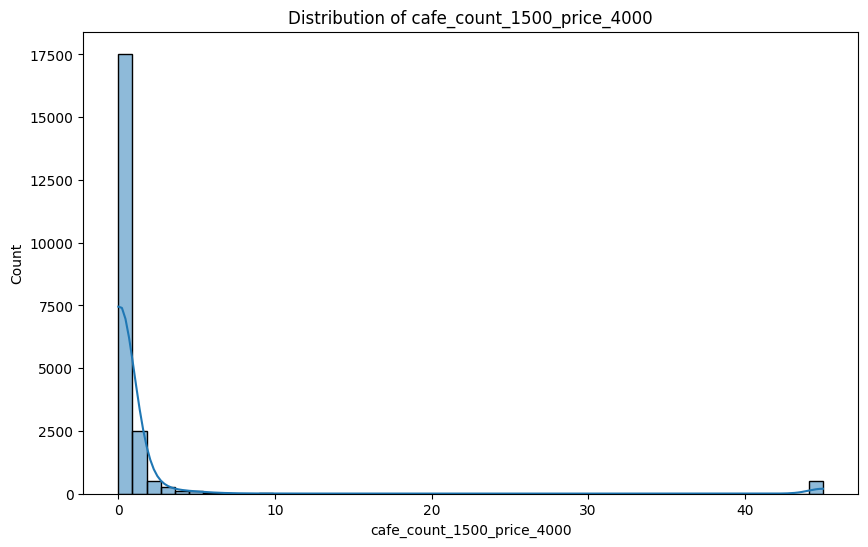

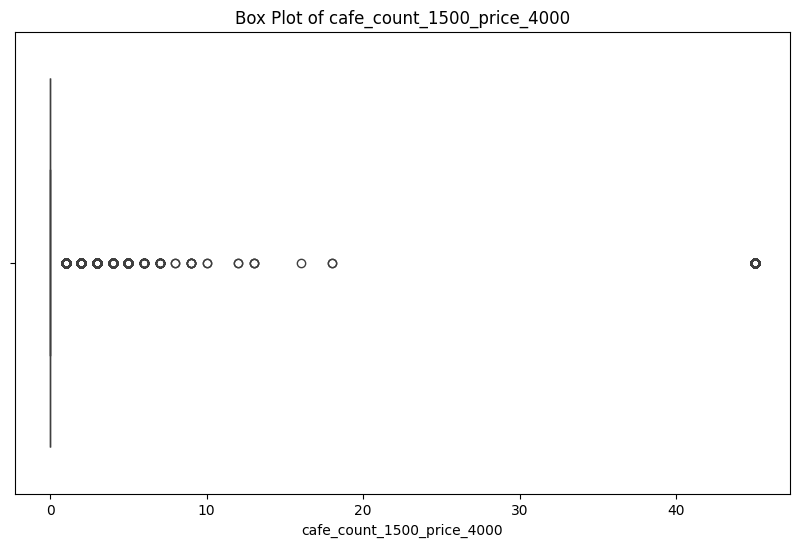

In [2323]:
col_to_visualize = 'cafe_count_1500_price_4000'
data_to_visualize = raw_data
data_to_visualize = data_with_outliers_removed
count_values_above_threshold(data_to_visualize, col_name=col_to_visualize)
visualize_target_distribution(data_to_visualize, col_to_visualize)

In [2240]:
# data = Data_train
data = data_with_outliers_removed

X = data.drop(columns=[target_column])
y = data[target_column]

In [2241]:
valeraInfo(X)

C:\Users\Nick\AppData\Local\Temp\ipykernel_16408\3045055618.py:20: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  info = info.style.applymap(color_cells, subset=['Тип данных'])


,Тип данных,Количесвто уникальных,Количество пропусков,Количество значений,%значений
id,int64,21571,0,21571,100.000000
timestamp,object,1155,0,21571,100.000000
full_sq,int64,76,0,21571,100.000000
life_sq,float64,66,5005,16566,76.800000
floor,float64,23,102,21469,99.530000
max_floor,float64,30,7294,14277,66.190000
material,float64,6,7294,14277,66.190000
build_year,float64,88,10393,11178,51.820000
num_room,float64,6,7294,14277,66.190000
kitch_sq,float64,19,7294,14277,66.190000


In [2242]:
def get_cols_containing(df, features):
    # Initialize an empty list to store columns
    count_columns = []
    # Iterate over the features to process and collect matching columns
    for feature in features:
        count_columns.extend([col for col in df.columns if feature in col])
    return df[count_columns]

df_cols = get_cols_containing(X, [
'university'
])
df_cols.head(1)


,university_top_20_raion,university_km
1,0,1.852560


In [2243]:
def create_accessibility_and_adequacy_features(df):
    df_copy = df.copy()

    # Normalize population data per km² (area in km² already normalized)
    df_copy['population_density'] = df_copy['full_all'] / (df_copy['area_m'] / 1_000_000)

    # Accessibility Features
    df_copy['child_facility_accessibility'] = df_copy['0_6_all'] / (df_copy['kindergarten_km'] + df_copy['preschool_km'] + 1e-6)
    df_copy['school_accessibility'] = df_copy['7_14_all'] / (df_copy['school_km'] + 1e-6)
    df_copy['university_accessibility'] = df_copy['16_29_all'] / (df_copy['university_km'] + 1e-6)
    df_copy['workplace_accessibility'] = df_copy['work_all'] / (df_copy['office_km'] + 1e-6)
    df_copy['elderly_healthcare_accessibility'] = df_copy['ekder_all'] / (df_copy['public_healthcare_km'] + 1e-6)

    # Adequacy Features (Reusing Accessibility)
    df_copy['child_facility_adequacy'] = df_copy['child_facility_accessibility'] / df_copy['population_density']
    df_copy['school_adequacy'] = df_copy['school_accessibility'] / df_copy['population_density']
    df_copy['university_adequacy'] = df_copy['university_accessibility'] / df_copy['population_density']
    df_copy['workplace_adequacy'] = df_copy['workplace_accessibility'] / df_copy['population_density']
    df_copy['elderly_healthcare_adequacy'] = df_copy['elderly_healthcare_accessibility'] / df_copy['population_density']

    # Log-transforming features to reduce skewness
    # for col in [
    #     'child_facility_accessibility', 'school_accessibility', 'university_accessibility',
    #     'workplace_accessibility', 'elderly_healthcare_accessibility',
    #     'child_facility_adequacy', 'school_adequacy', 'university_adequacy',
    #     'workplace_adequacy', 'elderly_healthcare_adequacy'
    # ]:
    #     df_copy[f'log_{col}'] = np.log1p(df_copy[col])

    return df_copy

def clean_up_accessibility_columns(df):
    df_copy = df.copy()

    # List of columns to drop (used for calculations)
    columns_to_drop = [
        'population_density', 'child_facility_accessibility', 'school_accessibility',
        'university_accessibility', 'workplace_accessibility', 'elderly_healthcare_accessibility',
        'child_facility_adequacy', 'school_adequacy', 'university_adequacy',
        'workplace_adequacy', 'elderly_healthcare_adequacy'
    ]
    
    # Drop the columns if they exist in the DataFrame
    df_copy.drop(columns=[col for col in columns_to_drop if col in df_copy.columns], inplace=True, errors='ignore')

    return df_copy

In [2244]:
X = create_accessibility_and_adequacy_features(X)

In [2245]:
city_center_features = ['mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'area_km']

def create_distance_based_features(df):
    df_copy = df.copy()

    # Convert area to km²
    df_copy['area_km'] = df_copy['area_m'] / 1_000_000

    # Normalize distance features by sub-area size, excluding city center features
    distance_features = [col for col in df.columns if '_km' in col and col not in city_center_features]
    for col in distance_features:
        df_copy[f'relative_{col}'] = df_copy[col] / (df_copy['area_km'] ** 0.5 + 1e-6)

    # Calculate weighted averages for accessibility groups, excluding city center features
    groups = {
        'public_transport_accessibility': ['metro_km_walk', 'metro_km_avto', 'public_transport_station_km'],
        'education_accessibility': ['kindergarten_km', 'school_km', 'university_km', 'preschool_km'],
        'healthcare_accessibility': ['public_healthcare_km', 'hospice_morgue_km'],
        'recreation_accessibility': ['park_km', 'green_zone_km', 'stadium_km', 'fitness_km', 'swim_pool_km'],
        'commerce_accessibility': ['shopping_centers_km', 'market_shop_km', 'big_market_km']
    }
    
    for group_name, group_features in groups.items():
        group_distances = [df_copy[col] for col in group_features if col in df_copy]
        df_copy[group_name] = sum(group_distances) / (len(group_features) + 1e-6)

    # Interaction with population density
    df_copy['population_density'] = df_copy['full_all'] / (df_copy['area_km'] + 1e-6)
    for group_name in groups.keys():
        df_copy[f'{group_name}_per_density'] = df_copy[group_name] / (df_copy['population_density'] + 1e-6)

    # Impact scores for distance features, excluding city center features
    for col in distance_features:
        if col in df_copy.columns:
            df_copy[f'impact_{col}'] = df_copy[col] / (df_copy['full_all'] + 1e-6)

    return df_copy

In [2246]:
def process_and_drop_cafe_price_columns(df):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Define price level weights
    price_weights = {
        '500': 1,
        '1000': 2,
        '1500': 3,
        '2500': 4,
        '4000': 5,
        'high': 6
    }

    # Define distance weights
    distance_weights = {
        '500': 1.5,
        '1000': 1.2,
        '1500': 1.0,
        '2000': 0.8,
        '3000': 0.6,
        '5000': 0.5
    }

    # Extract unique distance ranges from column names
    distance_ranges = sorted(set(col.split('_')[2] for col in df.columns if col.startswith('cafe_count_')), key=int)

    # Process each distance range
    for distance in distance_ranges:
        # Select price-related columns corresponding to the current distance range
        relevant_price_columns = [col for col in df.columns if f'cafe_count_{distance}_price_' in col]

        # Ensure columns are sorted by price level to align with weights
        relevant_price_columns.sort(key=lambda x: list(price_weights.keys()).index(x.split('_')[-1]))

        # Calculate weighted affordability score for this distance range
        df_copy[f'cafe_affordability_{distance}'] = df_copy[relevant_price_columns].dot(
            [price_weights[col.split('_')[-1]] for col in relevant_price_columns]
        )

        # Calculate accessibility score (weighted count) for this distance range
        count_column = f'cafe_count_{distance}'
        weight = distance_weights.get(distance, 1)  # Use provided weight or default to 1 if not specified
        if count_column in df_copy.columns:
            df_copy[f'cafe_accessibility_{distance}'] = df_copy[count_column] * weight

    # Identify all columns to drop
    columns_to_drop = [
        col for col in df_copy.columns
        if (
            # Drop price-related columns
            (col.startswith('cafe_count_') and '_price_' in col)
            # Drop na_price columns
            or (col.endswith('_na_price') and col.startswith('cafe_count_'))
            # Drop min/max/avg price columns
            or any(sub in col for sub in ['_min_price_avg', '_max_price_avg', '_avg_price_'])
            # Drop total count columns per distance
            or any(col == f'cafe_count_{distance}' for distance in distance_ranges)
        )
    ]

    # Drop the identified columns
    df_copy.drop(columns=columns_to_drop, inplace=True)

    # Sort new columns by distance range in ascending order
    sorted_columns = sorted(
        [col for col in df_copy.columns if col.startswith('cafe_affordability_') or col.startswith('cafe_accessibility_')],
        key=lambda x: int(x.split('_')[-1])
    )

    # Reorder columns to place sorted new columns at the end of the DataFrame
    df_copy = df_copy[[col for col in df_copy.columns if col not in sorted_columns] + sorted_columns]

    return df_copy


In [2247]:
def aggregate_affordability_accessibility(df):
    df_copy = df.copy()

    # Define weights for each distance range
    distance_weights = {
        '500': 1.5,
        '1000': 1.2,
        '1500': 1.0,
        '2000': 0.8,
        '3000': 0.6,
        '5000': 0.5
    }

    # Identify affordability and accessibility columns
    affordability_columns = [col for col in df.columns if col.startswith('cafe_affordability_')]
    accessibility_columns = [col for col in df.columns if col.startswith('cafe_accessibility_')]

    # Aggregate affordability
    df_copy['cafe_total_affordability'] = df_copy[affordability_columns].dot(
        [distance_weights[col.split('_')[-1]] for col in affordability_columns]
    )

    # Aggregate accessibility
    df_copy['cafe_total_accessibility'] = df_copy[accessibility_columns].dot(
        [distance_weights[col.split('_')[-1]] for col in accessibility_columns]
    )

    # Drop individual distance-specific columns
    df_copy.drop(columns=affordability_columns + accessibility_columns, inplace=True)

    return df_copy


In [2248]:
X = process_and_drop_cafe_price_columns(X)
X = aggregate_affordability_accessibility(X)

In [2249]:
def calculate_incremental_counts(df, base_column):
    df_copy = df.copy()
    distances = sorted(
        [col.split('_')[-1] for col in df.columns if col.startswith(base_column) and col.split('_')[-1].isdigit()],
        key=int
    )

    for i, distance in enumerate(distances):
        current_col = f"{base_column}{distance}"
        if i == 0:
            # First distance, no need to subtract
            df_copy[f"incremental_{current_col}"] = df_copy[current_col]
        else:
            prev_col = f"{base_column}{distances[i - 1]}"
            df_copy[f"incremental_{current_col}"] = df_copy[current_col] - df_copy[prev_col]
    
    return df_copy


In [2250]:
def aggregate_weighted_counts(df, base_column, distance_weights):
    # Extract distances from columns and sort them numerically
    distances = sorted(
        [col.split('_')[-1] for col in df.columns if col.startswith(f"incremental_{base_column}")],
        key=int
    )
    
    # Initialize weighted score to 0
    weighted_score = 0
    
    # Accumulate weighted scores for each distance
    for distance in distances:
        col_name = f"incremental_{base_column}{distance}"
        if col_name in df.columns:  # Ensure the column exists in the dataframe
            weighted_score += df[col_name] * distance_weights.get(distance, 1)
    
    return weighted_score


In [2251]:
# Drop columns used to calculate sport_count_weighted, but keep sport_count_weighted
def drop_sport_count_columns(df, base_column):
    # Identify columns to drop for incremental counts and base counts
    columns_to_drop = [
        col for col in df.columns 
        if (col.startswith(f"incremental_{base_column}") or col.startswith(base_column))
        and col != f"{base_column}weighted"  # Keep sport_count_weighted
    ]
    
    # Drop the identified columns
    df = df.drop(columns=columns_to_drop, inplace=False)  # inplace=False ensures a new DataFrame is returned
    
    return df

In [2252]:
feature_distance_weights = {
    'sport_count_': {'500': 1.49, '1000': 1.26, '1500': 1.35, '2000': 1.29, '3000': 5.00, '5000': 1.41},
    'office_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'trc_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'big_church_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'church_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'mosque_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'leisure_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'market_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'trc_sqm_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'office_sqm_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
}

# Process and aggregate distance-weighted features
def process_distance_features(X, feature_distance_weights):
    for feature, distance_weights in feature_distance_weights.items():
        # Calculate incremental counts for the current feature
        X = calculate_incremental_counts(X, feature)
        
        # Aggregate the counts into a single weighted score
        X[f'{feature}weighted'] = aggregate_weighted_counts(X, feature, distance_weights)
        
        # Drop the incremental columns for the current feature
        X = drop_sport_count_columns(X, feature)  # Ensure this function handles all *_distance* features

    return X

In [2253]:
X = process_distance_features(X, feature_distance_weights)

In [2254]:
def drop_redundant_columns(df, feature_prefix, weight_dict):
    # Generate column names to drop based on the prefix and keys of the weight dictionary
    columns_to_drop = [f"{feature_prefix}_{suffix}" for suffix in weight_dict.keys()]
    # Drop the columns
    return df.drop(columns=columns_to_drop, errors='ignore')

In [2255]:
def calculate_weighted_build_count(df, construction_weights):
    weighted_build_count = sum(
        df[f'build_count_{period}'] * weight
        for period, weight in construction_weights.items()
    )
    return weighted_build_count

In [2256]:
construction_weights = {
    'before_1920': 1,
    '1921-1945': 2,
    '1946-1970': 3,
    '1971-1995': 4,
    'after_1995': 5
}

X['weighted_build_count'] = calculate_weighted_build_count(X, construction_weights)
X = drop_redundant_columns(X, 'build_count', construction_weights)

In [2257]:
def calculate_weighted_material_score(df, material_weights):
    weighted_score = sum(
        df[f'build_count_{material}'] * weight
        for material, weight in material_weights.items()
    )
    df['weighted_material_score'] = weighted_score
    return df

In [2258]:
material_weights = {
    'block': 1.2,
    'wood': 0.5,
    'frame': 1.0,
    'brick': 1.5,
    'monolith': 2.0,
    'panel': 0.8,
    'foam': 0.7,
    'slag': 0.6,
    'mix': 1.1
}

X = calculate_weighted_material_score(X, material_weights)
X = drop_redundant_columns(X, 'build_count', material_weights)

In [2259]:
def weighted_average_aggregation(X, feature_base_name, distance_weights):
    # Calculate the weighted average
    weighted_column = f"{feature_base_name}_weighted"
    X[weighted_column] = sum(
        X[f"{feature_base_name}_{distance}"] * weight
        for distance, weight in distance_weights.items()
    ) / sum(distance_weights.values())
    
    return X

In [2260]:
green_weights = {'500': 5, '1000': 4, '1500': 3, '2000': 2, '3000': 1, '5000': 0.5}
prom_weights = {'500': 5, '1000': 4, '1500': 3, '2000': 2, '3000': 1, '5000': 0.5}

X = weighted_average_aggregation(X, 'green_part', green_weights)
X = weighted_average_aggregation(X, 'prom_part', prom_weights)

X = drop_redundant_columns(X, 'green_part', green_weights)
X = drop_redundant_columns(X, 'prom_part', prom_weights)

In [2261]:
def get_cols_containing(df, features):
    # Initialize an empty list to store columns
    count_columns = []
    # Iterate over the features to process and collect matching columns
    for feature in features:
        count_columns.extend([col for col in df.columns if feature in col])
    return df[count_columns]

df_cols = get_cols_containing(X, [
'full_all',
'male_f',
'female_f',
'young_all',
'young_male',
'young_female',
'work_all',
'work_male',
'work_female',
'ekder_all',
'ekder_male',
'ekder_female',
'0_6_all',
'0_6_male',
'0_6_female',
'7_14_all',
'7_14_male',
'7_14_female',
'0_17_all',
'0_17_male',
'0_17_female',
'16_29_all',
'16_29_male',
'16_29_female',
'0_13_all',
'0_13_male',
'0_13_female',
])
df_cols.head(1)


,full_all,male_f,female_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female
1,76284,34200,42084,42084,15727,7925,7802,70194,35622,34572,29431,9266,20165,6880,3466,3414,7759,3909,3850,17700,8998,8702,15164,7571,7593,13729,6929,6800


In [2262]:
def process_demographic_features(df):
    # Ensure no division by zero
    df['full_all'] = df['full_all'].replace(0, pd.NA)
    
    # Normalize features by total population
    df['male_ratio'] = df['male_f'] / df['full_all']
    df['female_ratio'] = df['female_f'] / df['full_all']
    
    # Gender balance ratio
    df['male_female_ratio'] = df['male_f'] / df['female_f']
    
    # Normalize age groups
    df['young_ratio'] = df['young_all'] / df['full_all']
    df['working_ratio'] = df['work_all'] / df['full_all']
    df['elderly_ratio'] = df['ekder_all'] / df['full_all']
    
    # Aggregate age groups
    df['youth_ratio'] = df['16_29_all'] / df['full_all']
    
    # Dependency ratios
    df['child_dependency_ratio'] = df['young_ratio'] / df['working_ratio']
    df['elderly_dependency_ratio'] = df['elderly_ratio'] / df['working_ratio']
    df['total_dependency_ratio'] = (
        df['young_ratio'] + df['elderly_ratio']
    ) / df['working_ratio']
    
    # Gender ratios for age groups
    df['young_male_ratio'] = df['young_male'] / df['young_all']
    df['work_male_ratio'] = df['work_male'] / df['work_all']
    df['elderly_male_ratio'] = df['ekder_male'] / df['ekder_all']
    
    return df

In [2263]:
X = process_demographic_features(X)

In [2264]:
def improve_top_features(df, target):
    df = df.copy()
    
    # Ensure target is aligned with df
    if len(df) != len(target):
        raise ValueError("The length of df and target must be the same.")

    # Add the target as a temporary column to calculate the group mean
    df['target_temp'] = target

    # Sub-area encoding: Compute mean of target and map to sub_area
    sub_area_mean_target = df.groupby('sub_area')['target_temp'].mean()
    df['sub_area_mean'] = df['sub_area'].map(sub_area_mean_target).fillna(0)  # Fill missing values

    # Drop the temporary target column
    df.drop(columns=['target_temp'], inplace=True)

    # Feature interactions
    df['log_full_sq'] = np.log1p(df['full_sq'].clip(lower=0))
    df['full_sq_per_room'] = df['full_sq'] / (df['num_room'] + 1e-6)
    df['avg_room_size'] = df['full_sq'] / (df['num_room'] + 1e-6)
    df['cafe_affordability_per_density'] = df['cafe_total_affordability'] / (df['population_density'] + 1e-6)
    df['num_room_category'] = pd.cut(df['num_room'].fillna(0), bins=[0, 1, 3, 5, np.inf], labels=['Small', 'Medium', 'Large', 'Very Large'])
    df['kremlin_proximity_bin'] = pd.cut(df['kremlin_km'].fillna(np.inf), bins=[0, 2, 5, 10, np.inf], labels=['Very Close', 'Close', 'Moderate', 'Far'])

    # Building age and categories
    current_year = 2024
    df['building_age'] = current_year - df['build_year'].fillna(current_year)
    df['building_age_bin'] = pd.cut(df['building_age'], bins=[0, 10, 30, 100, np.inf], labels=['New', 'Modern', 'Old', 'Historic'])
    df['floor_ratio'] = df['floor'] / (df['max_floor'] + 1e-6)

    # City center proximity
    df['city_center_proximity'] = df[['kremlin_km', 'sadovoe_km', 'ttk_km', 'mkad_km']].mean(axis=1, skipna=True)

    # Building age and state interaction
    df['state_age_interaction'] = df['state'] * df['building_age']

    # Youth ratio normalization
    df['normalized_youth_ratio'] = df['youth_ratio'] / (df['area_m'] / 1_000_000 + 1e-6)

    return df


In [2265]:
# X = improve_top_features(X, y)

In [2266]:
def drop_initial_population_columns(df):
    columns_to_drop = [
        'male_f', 'female_f',
        'young_all', 'young_male', 'young_female',
        'work_all', 'work_male', 'work_female',
        'ekder_all', 'ekder_male', 'ekder_female',
        '0_6_all', '0_6_male', '0_6_female',
        '7_14_all', '7_14_male', '7_14_female',
        '0_17_all', '0_17_male', '0_17_female',
        '16_29_all', '16_29_male', '16_29_female',
        '0_13_all', '0_13_male', '0_13_female',
        'children_preschool', 'children_school', 'full_all',
    ]
    return df.drop(columns=columns_to_drop, inplace=False)

In [2267]:
def drop_institutional_related_columns(df):
    columns_to_drop = [
        'preschool_quota',
        'preschool_education_centers_raion',
        'school_quota',
        'school_education_centers_raion',
        'school_education_centers_top_20_raion',
        'hospital_beds_raion',
        'healthcare_centers_raion',
        'university_top_20_raion',
        'sport_objects_raion',
        'additional_education_raion',
        'culture_objects_top_25_raion',
        'shopping_centers_raion'
    ]
    
    return df.drop(columns=columns_to_drop, errors='ignore')

In [2268]:
def drop_initial_km_features(df):
    # Identify columns to drop
    columns_to_drop = [col for col in df.columns if '_km' in col and col not in city_center_features]
    
    # Drop the identified columns
    return df.drop(columns=columns_to_drop, errors='ignore')

In [2269]:
def drop_initial_features(df):
    df = drop_initial_population_columns(df)
    df = drop_initial_km_features(df)
    df = drop_institutional_related_columns(df)
    return df

In [2270]:
X = drop_initial_features(X)

In [2271]:
def drop_specific_features(df):
    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Define keywords to identify population, gender, count, and office_sqm columns to drop
    keywords_to_drop = [
        '_count_',      # General count, but will exclude those prefixed by 'build_count'
        '_all', '_male', '_female',  # Gender and population age groups
        'popul', 'young_', 'work_', 'ekder_',  # Population-related prefixes
        'office_sqm_'   # Office area features to drop
    ]
    
    # Define exceptions to keep certain count columns, like 'build_count'
    exceptions_to_keep = [
        'build_count'
    ]
    
    # Identify columns to drop based on keywords, but keep exceptions
    columns_to_drop = [
        col for col in df_copy.columns
        if any(keyword in col for keyword in keywords_to_drop) and
           not any(exception in col for exception in exceptions_to_keep)
    ]
    
    # Drop the identified columns
    df_copy.drop(columns=columns_to_drop, inplace=True)
    
    return df_copy

# X = drop_specific_features(X)

In [2272]:
date_column = 'timestamp'
year_column = 'year_of_transaction'

X = X.copy()
X[date_column] = pd.to_datetime(X[date_column], errors='coerce')
X[year_column] = X[date_column].dt.year
X = X.drop(columns=[date_column])

In [2273]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()

print(len(X.columns))
print(len(numerical_columns))
print(len(categorical_columns))

90
75
15


In [2274]:
# numeric_cols_with_missing_values = [col for col in numerical_columns if X[col].isna().any()]
# print(len(numeric_cols_with_missing_values))

In [2275]:
# Code block
binary_categories_columns = [binary_category_column] + boolean_category_columns
categorical_columns = [ecology_column] + binary_categories_columns + [sub_area_column]
all_columns = categorical_columns + numerical_columns
ecology_index = all_columns.index(ecology_column)

In [2276]:
class KNNModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        self.knn = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.knn.fit(X[~np.isnan(X).any(axis=1)])
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        col_data = X[:, 0].reshape(-1, 1)
        nan_mask = np.isnan(col_data)
        
        # Ensure there are NaNs to be imputed
        if not nan_mask.any():
            return X
        
        # Find nearest neighbors for rows without NaN values
        distances, neighbors = self.knn.kneighbors(col_data[~nan_mask].reshape(-1, 1))
        
        for i, idx in enumerate(np.where(nan_mask)[0]):
            neighbor_vals = col_data[neighbors[i]].flatten()
            mode_result = mode(neighbor_vals, nan_policy='omit')
            count_value = mode_result.count if np.isscalar(mode_result.count) else mode_result.count[0]
            imputed_value = mode_result.mode if np.isscalar(mode_result.mode) else mode_result.mode[0]
            col_data[idx, 0] = imputed_value
        
        # Ensure column assignment back to X
        X[:, 0] = col_data.flatten()
        
        return X


In [2277]:
class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)

In [2278]:
columns_for_numeric_knn_imputation = [col for col in all_columns if col != ecology_column]

preprocessing_pipeline = Pipeline([
    (
        'encoding',
        ColumnTransformer([
            (
                'ecology_ordinal', 
                OrdinalEncoder(
                    categories=[['poor', 'satisfactory', 'good', 'excellent']], 
                    handle_unknown='use_encoded_value', 
                    unknown_value=np.nan
                ), 
                [ecology_column]
            ),
            (
                'binary_ohe',
                OneHotEncoder(sparse_output=False, drop='if_binary'),
                binary_categories_columns
            ),
            (
                'sub_area_target',
                TargetEncoder(),
                [sub_area_column]
            ),
            (
                'numerical',
                'passthrough',
                numerical_columns
            )
        ])
    ),
    # ('scaling', StandardScaler()),
    # ('to_dataframe_after_scaling', DataFrameConverter(columns=all_columns)),
    # (
        # 'knn_imputation',
        # ColumnTransformer([
            # (
                # 'ecology',
                # 'passthrough',
                # [ecology_column]
            # ),
            # (
                # 'knn_imputer',
                # KNNImputer(n_neighbors=3),
                # columns_for_numeric_knn_imputation
            # )
        # ])
    # ),
    # # ('to_dataframe_after_knn_imputation', DataFrameConverter(columns=all_columns)),
    # (
    #     'ecology_imputation',
    #     ColumnTransformer(
    #         transformers=[(
    #             'knn_mode_imputer',
    #             KNNModeImputer(n_neighbors=3),
    #             [ecology_column]
    #         )],
    #         remainder='passthrough'
    #     )
    # )
])

In [2279]:
# pca_pipeline = Pipeline([
#     ('preprocessing', preprocessing_pipeline),
#     ('pca', PCA(n_components=0.95))  # Retain 95% of the variance
# ])

# X_pca = pca_pipeline.fit_transform(X, y)

# print("Original number of features:", X.shape[1])
# print("Reduced number of features after PCA:", X_pca.shape[1])

In [2280]:
# X_processed = processing_pipeline.fit_transform(X, y)
# X_processed_df = pd.DataFrame(X_processed, columns=all_columns)

In [2281]:
# numeric_cols_with_missing_values = [col for col in numerical_columns if X_processed_df[col].isna().any()]
# cols_with_missing_values = [col for col in all_columns if X_processed_df[col].isna().any()]
# print("numeric columns with missing values:", len(numeric_cols_with_missing_values))
# print("all columns with missing values:", len(cols_with_missing_values))
# print("ecology column after imputation:", X_processed_df[ecology_column].unique())

In [2282]:
# raise ValueError("This is a custom error message")

In [2283]:
X_processed = preprocessing_pipeline.fit_transform(X, y)

In [2284]:
reduced_features = ['num_room', 'sub_area', 'full_sq', 'trc_count_weighted', 'cafe_total_affordability', 'sport_count_weighted', 'raion_build_count_with_builddate_info', 'office_sqm_weighted', 'product_type', 'leisure_count_weighted', 'cafe_total_accessibility', 'year_of_transaction', 'bulvar_ring_km', 'trc_sqm_weighted', 'ttk_km', 'kitch_sq', 'build_year', 'life_sq', 'weighted_material_score', 'indust_part', 'max_floor', 'youth_ratio', 'elderly_healthcare_accessibility', 'sadovoe_km', 'prom_part_weighted', 'elderly_healthcare_adequacy', 'child_facility_accessibility', 'weighted_build_count', 'culture_objects_top_25']
reduced_features_ordered = [col for col in all_columns if col in reduced_features]

In [2285]:
# feature_columns = reduced_features_ordered
feature_columns = all_columns

In [2286]:
# Convert X_processed to a DataFrame if it's in NumPy format
X_processed_df = pd.DataFrame(X_processed, columns=all_columns)  # `all_columns` should be your original list of column names

# Filter the DataFrame to include only the reduced set of features
X_reduced_df = X_processed_df[feature_columns]

# If you need it back as a NumPy array, convert it here
X_reduced = X_reduced_df.to_numpy()

In [2287]:
# X_reduced_df.columns

In [2288]:
# X_split = X_reduced
X_split = X_reduced
print(X_split.shape[1])
print(X_split.shape[0])

90
21571


In [2289]:
X_train, X_test, y_train, y_test = train_test_split(X_split, y, test_size=0.2, random_state=42)

In [2290]:
model = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)

# model = XGBRegressor(
#     colsample_bytree=0.6,
#     learning_rate=0.01,
#     max_depth=4,
#     n_estimators=50,
#     subsample=1.0,
#     random_state=42
# )

In [2291]:
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate metrics using cross-validated predictions
cv_mse = mean_squared_error(y_train, cv_predictions)
cv_rmse = np.sqrt(cv_mse)
cv_r2 = r2_score(y_train, cv_predictions)

print(f"Cross-Validated RMSE: {cv_rmse}")
print(f"Cross-Validated R^2 Score: {cv_r2}")

Cross-Validated RMSE: 1894165.8431876195
Cross-Validated R^2 Score: 0.46869146823883057


In [2292]:
model.fit(X_train, y_train)
test_predictions = model.predict(X_test)

# Calculate test metrics
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {test_rmse}")
print(f"Test R^2 Score: {test_r2}")

Test RMSE: 1884616.6887258105
Test R^2 Score: 0.4892093539237976


In [2293]:
# Assuming X_test is preprocessed and ready for predictions
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate Mean Squared Logarithmic Error
msle = mean_squared_log_error(y_test, y_pred)

print(f"Mean Squared Logarithmic Error (MSLE): {msle}")

Mean Squared Logarithmic Error (MSLE): 0.20874824091986052


In [2294]:
model_fi = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)

In [2295]:
print(len(X_test))
print(len(y_test))
print(len(X_split))
print(len(y))

4315
4315
21571
21571


In [2296]:
model_fi.fit(X_train, y_train)
importances = model_fi.feature_importances_
len(importances)

90

In [2297]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.index = range(1, len(feature_importance_df) + 1)
feature_importance_df.index.name = 'Rank'

print(feature_importance_df)

                                    Feature  Importance
Rank                                                   
1                                  num_room    0.128259
2                                  sub_area    0.101661
3                                   full_sq    0.048620
4                        trc_count_weighted    0.039162
5                  cafe_total_affordability    0.023151
6                      sport_count_weighted    0.020761
7                              product_type    0.016078
8     raion_build_count_with_builddate_info    0.014900
9          elderly_healthcare_accessibility    0.013902
10                               kremlin_km    0.013643
11                               build_year    0.013050
12                                 kitch_sq    0.012492
13                           bulvar_ring_km    0.012344
14                                  life_sq    0.012308
15                 cafe_total_accessibility    0.011901
16                    office_count_weighted    0

In [2298]:
raise ValueError("This is a custom error message")

ValueError: This is a custom error message

In [ ]:
importance_threshold = 0.009
features_all = feature_importance_df['Feature'].tolist()
features_to_keep = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]['Feature'].tolist()
print(len(features_to_keep))
print(len(features_all))

In [ ]:
# Check features that are being kept and dropped based on the threshold
features_below_threshold = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]
features_above_threshold = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]

print("Number of features below threshold:", len(features_below_threshold))
print("Number of features above threshold:", len(features_above_threshold))

# Display the list of features below the threshold to inspect
# print("Features below the threshold of importance:")
# print(features_below_threshold[['Feature', 'Importance']].sort_values(by='Importance', ascending=True))

features_to_keep = features_above_threshold['Feature'].tolist()
print("Features to keep (for hard-coding):")
print(features_to_keep)



# To verify the exact number of features to drop
features_to_drop = features_below_threshold['Feature'].tolist()
print(f"Number of features to drop: {len(features_to_drop)}")


In [ ]:
# Define the model
model = XGBRegressor(random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'max_depth': [4, 6, 8],              # Maximum tree depth
    'subsample': [0.6, 0.8, 1.0],        # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0]  # Subsample ratio of columns for each split
}

# Define the RMSE scorer (lower is better for RMSE)
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmse_scorer,  # Use RMSE as the evaluation metric
    cv=5,                 # 5-fold cross-validation
    verbose=1,            # Show progress during search
    n_jobs=-1             # Use all available CPUs
)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and the corresponding RMSE
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE Score (Validation):", grid_search.best_score_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_predictions = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {test_rmse}")
print(f"Test R^2 Score: {test_r2}")

In [ ]:
# Define the model
model = XGBRegressor(random_state=42)

# Define a refined parameter grid based on insights
param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Define a custom RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    scoring=rmse_scorer,     # Use RMSE as the evaluation metric
    n_iter=500,               # Number of parameter combinations to try
    cv=5,                    # 5-fold cross-validation
    verbose=3,               # Print detailed progress
    random_state=42,         # For reproducibility
    n_jobs=-1,               # Use all available CPUs
    error_score="raise"      # Raise errors instead of ignoring them
)

# Fit the search on your data
random_search.fit(X_train, y_train)

# Get the best parameters and RMSE score
best_params = random_search.best_params_
best_rmse = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best RMSE Score (Validation): {best_rmse}")

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
test_predictions = best_model.predict(X_test)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {test_rmse}")
print(f"Test R^2 Score: {test_r2}")


In [ ]:
array1 = ['office_sqm_5000', 'cafe_count_3000_price_2500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_1000', 'num_room', 'sub_area', 'full_sq', 'cafe_count_1500_price_500', 'cafe_count_5000_price_1500', 'cafe_count_3000_price_1500', 'cafe_count_2000', 'cafe_count_1500_price_2500', 'cafe_count_3000', 'big_market_raion', 'cafe_avg_price_5000', 'big_church_count_2000', 'cafe_count_2000_price_2500', 'cafe_avg_price_2000', 'build_count_monolith', 'sadovoe_km', 'life_sq', 'church_count_5000', 'healthcare_centers_raion', 'cafe_count_1500_price_high', 'cafe_count_2000_price_high', 'sport_count_3000', 'cafe_count_2000_price_1500', 'raion_build_count_with_material_info', 'leisure_count_3000', 'children_preschool', 'big_road1_1line', 'cafe_count_3000_price_1000', 'cafe_count_5000', 'cafe_count_2000_price_1000', 'state', 'big_church_count_1500', 'office_count_5000', 'cafe_count_1500_price_1500', 'shopping_centers_km', 'green_part_1500', 'swim_pool_km', 'green_part_5000', 'office_sqm_2000', 'cafe_sum_2000_min_price_avg', 'build_count_brick', 'zd_vokzaly_avto_km', 'children_school', 'cafe_count_3000_price_high', 'cafe_count_500_price_1500', 'cafe_count_5000_na_price', 'indust_part', 'incineration_km', 'market_count_1500', 'railroad_station_walk_km', 'cafe_count_2000_na_price', 'kitch_sq', 'public_transport_station_min_walk', 'mosque_km', 'theater_km', 'office_count_1500', 'railroad_km', 'cafe_count_1000_price_1500', 'church_count_2000', 'ttk_km', 'detention_facility_km', 'ID_railroad_station_walk', 'cafe_count_5000_price_4000', 'hospital_beds_raion', 'big_road1_km', 'leisure_count_5000', 'office_count_500', 'market_count_5000', 'fitness_km', 'radiation_km', 'full_all', 'cafe_count_1000', 'green_zone_part', 'cafe_avg_price_3000', 'cafe_count_1500_price_4000', 'cafe_sum_5000_max_price_avg', 'kremlin_km', 'green_part_500', 'green_part_1000', 'sport_count_500', 'cafe_count_5000_price_high', '0_17_female', 'build_count_panel', 'cafe_count_1000_price_500', 'office_sqm_3000', 'railroad_station_walk_min', 'build_count_1921-1945', 'school_quota', 'power_transmission_line_km', 'metro_km_avto', 'prom_part_3000', 'prom_part_5000', 'green_zone_km', 'ID_big_road1', 'trc_count_3000', 'office_sqm_1500', 'cafe_count_1500', 'public_transport_station_km', 'cemetery_km', 'cafe_count_500_price_high', 'ID_metro', 'cafe_count_500', 'year', 'trc_sqm_3000', 'cafe_count_1000_price_1000', 'trc_sqm_2000', 'culture_objects_top_25_raion', 'mkad_km', 'nuclear_reactor_km', 'office_count_2000', 'industrial_km', 'basketball_km', 'cafe_sum_3000_max_price_avg', 'cafe_sum_1500_min_price_avg', 'additional_education_km', 'preschool_quota', 'cafe_count_5000_price_500', 'cafe_sum_2000_max_price_avg', 'young_all', 'raion_popul', 'big_church_count_500', 'ekder_all', 'build_count_wood', 'young_male', 'workplaces_km', 'sport_count_2000', 'cafe_count_500_price_4000', 'cafe_count_2000_price_4000', 'railroad_station_avto_min', 'thermal_power_plant_km', 'cafe_count_3000_price_4000', 'office_count_1000', 'ts_km', 'catering_km', 'build_count_slag', 'ID_bus_terminal', 'cafe_avg_price_1500', 'green_part_3000', 'oil_chemistry_km', 'office_count_3000', 'stadium_km', 'water_km', 'prom_part_1500', 'build_year', 'build_count_block', 'id', 'exhibition_km', 'university_km', 'office_sqm_500', 'museum_km', 'work_all', 'build_count_before_1920', 'cafe_count_1000_price_2500', 'leisure_count_1000', 'build_count_frame', 'cafe_count_2000_price_500', 'cafe_count_500_na_price', 'cafe_count_500_price_2500', 'cafe_count_500_price_500', 'cafe_count_3000_na_price', 'big_church_km', 'shopping_centers_raion', 'ekder_male', 'max_floor', 'build_count_1971-1995', 'build_count_foam', 'water_treatment_km', 'build_count_1946-1970', 'green_part_2000', 'product_type', 'church_count_1500', 'cafe_count_1000_price_4000', 'trc_count_1500', 'market_count_2000', 'trc_count_1000', 'floor', 'big_market_km', 'cafe_sum_3000_min_price_avg', 'park_km', 'cafe_count_1500_price_1000', 'kindergarten_km', 'preschool_km', 'cafe_sum_1000_max_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_sum_500_max_price_avg', 'market_shop_km', 'public_healthcare_km', 'prom_part_500', 'hospice_morgue_km', 'big_church_count_1000', 'ID_railroad_terminal', 'metro_min_walk', 'sport_count_1500', 'cafe_count_3000_price_500', 'leisure_count_2000', 'office_sqm_1000', 'material', 'trc_sqm_5000', 'raion_build_count_with_builddate_info', 'area_m', 'trc_count_5000', 'work_male', 'office_km', 'office_raion', 'metro_min_avto', 'big_road2_km', 'prom_part_2000', 'bus_terminal_avto_km', 'trc_sqm_500', 'mosque_count_5000', 'sport_objects_raion', 'church_synagogue_km', 'big_church_count_5000', 'ice_rink_km', 'trc_count_500', 'sport_count_1000', 'church_count_1000', 'railroad_station_avto_km', 'preschool_education_centers_raion', 'female_f']
array2 = ['office_sqm_5000', 'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500', 'num_room', 'cafe_count_1500_price_2500', 'sub_area', 'full_sq', 'cafe_count_3000', 'church_count_5000', 'cafe_count_2000', 'cafe_count_3000_price_high', 'big_church_count_2000', 'cafe_avg_price_5000', 'cafe_avg_price_2000', 'life_sq', 'sport_count_3000', 'cafe_count_1500_price_1500', 'sadovoe_km', 'cafe_count_3000_price_1000', 'swim_pool_km', 'build_count_monolith', 'cafe_count_2000_price_2500', 'cafe_count_1500_price_high', 'cafe_count_2000_price_1000', 'indust_part', 'state', 'cafe_count_2000_price_high', 'ttk_km', 'leisure_count_1500', 'healthcare_centers_raion', 'cafe_count_3000_price_4000', 'trc_count_5000', 'zd_vokzaly_avto_km', 'cafe_count_1000_price_1000', 'cafe_count_2000_price_1500', 'office_count_500', 'trc_count_2000', 'leisure_count_3000', 'green_part_5000', 'cafe_sum_1500_min_price_avg', 'preschool_quota', 'railroad_station_walk_min', 'railroad_station_walk_km', 'public_transport_station_min_walk', 'cafe_count_1000_price_high', 'young_all', 'cafe_count_1000', 'green_part_1000', 'culture_objects_top_25', 'office_raion', 'kitch_sq', 'raion_build_count_with_material_info', 'ekder_all', 'cafe_count_5000_na_price', 'cafe_count_5000_price_high', 'green_part_1500', 'industrial_km', 'railroad_km', 'cafe_sum_3000_max_price_avg', 'prom_part_3000', 'trc_count_1500', 'ID_railroad_station_walk', 'ts_km', '7_14_female', 'office_count_1500', 'ekder_male', 'green_zone_part', 'cafe_count_2000_price_500', 'ID_bus_terminal', 'cafe_count_1500_price_4000', 'cafe_count_2000_price_4000', 'children_preschool', 'ekder_female', 'cemetery_km', 'trc_count_3000', 'cafe_count_5000_price_1000', 'cafe_count_5000', 'mosque_km', 'leisure_count_2000', 'incineration_km', 'radiation_km', 'hospital_beds_raion', 'ID_big_road1', 'cafe_count_5000_price_4000', '16_29_all', 'prom_part_5000', 'big_road1_1line', 'shopping_centers_km', 'market_count_3000', 'public_transport_station_km', 'big_market_raion', 'additional_education_km', 'market_count_500', 'fitness_km', 'build_count_before_1920', 'young_male', 'big_road2_km', 'young_female', 'cafe_sum_1000_max_price_avg', 'ID_metro', 'office_count_3000', 'sport_count_1500', 'office_sqm_500', 'bulvar_ring_km', 'mkad_km', 'cafe_sum_2000_max_price_avg', 'school_quota', 'build_count_panel', 'metro_km_avto', 'catering_km', 'museum_km', 'cafe_count_1000_price_1500', 'cafe_sum_2000_min_price_avg', 'public_healthcare_km', 'office_sqm_3000', 'build_year', 'exhibition_km', 'nuclear_reactor_km', 'cafe_count_1000_price_2500', 'trc_sqm_2000', 'power_transmission_line_km', 'big_market_km', 'cafe_sum_1500_max_price_avg', 'year', 'water_km', 'university_km', 'build_count_block', 'max_floor', 'trc_sqm_5000', 'cafe_sum_500_min_price_avg', 'build_count_1971-1995', 'theater_km', 'park_km', 'build_count_1921-1945', 'cafe_count_500_price_1000', 'detention_facility_km', 'kremlin_km', 'sport_objects_raion', 'id', 'cafe_count_1000_price_500', 'oil_chemistry_km', 'water_treatment_km', '0_17_female', 'cafe_count_500_na_price', 'green_zone_km', 'basketball_km', 'prom_part_1500', 'cafe_avg_price_3000', 'cafe_count_500', 'cafe_avg_price_500', 'cafe_count_1500_na_price', 'kindergarten_km', 'green_part_3000', 'build_count_wood', 'big_church_km', 'sport_count_1000', 'trc_sqm_500', 'sport_count_5000', 'build_count_foam', 'ID_railroad_station_avto', 'cafe_sum_3000_min_price_avg', 'office_count_2000', 'build_count_1946-1970', 'trc_count_1000', 'thermal_power_plant_km', '16_29_male', 'cafe_count_2000_na_price', 'raion_popul', 'church_count_1500', 'metro_min_walk', 'trc_sqm_3000', 'stadium_km', 'prom_part_1000', 'cafe_count_500_price_500', 'school_km', 'female_f', 'floor', 'cafe_count_500_price_1500', 'office_km', 'cafe_count_1000_price_4000', 'railroad_station_avto_min', 'cafe_count_3000_na_price', 'leisure_count_1000', 'office_count_1000', 'ID_big_road2', 'metro_min_avto', 'build_count_brick', 'big_church_count_500', 'cafe_sum_5000_max_price_avg', 'green_part_500', 'trc_sqm_1000', 'workplaces_km', 'bus_terminal_avto_km', 'cafe_count_1500', 'big_church_count_5000', 'school_education_centers_raion', '0_6_male', 'product_type', 'cafe_sum_1000_min_price_avg', 'green_part_2000', 'ID_railroad_terminal', 'cafe_count_1500_price_500', 'office_count_5000', 'railroad_station_avto_km', 'cafe_count_500_price_4000', 'sport_count_500', 'big_road1_km', 'office_sqm_1500', 'prom_part_2000', 'market_shop_km', 'cafe_sum_5000_min_price_avg', 'office_sqm_2000', 'culture_objects_top_25_raion', 'cafe_count_1000_na_price', 'church_synagogue_km', 'preschool_km', 'ice_rink_km']

common_elements = list(set(array1) & set(array2))
print("Common elements:", len(common_elements))

In [ ]:
# Calculate variances
feature_variances = X_processed_df.var()

# Set threshold for variance
threshold = 0.2

# Select features with variance above the threshold
selected_features = feature_variances[feature_variances > threshold].index
removed_features = feature_variances[feature_variances <= threshold].index

# Print the results
print("Selected Features Count:", len(selected_features))
print("Removed Features Count:", len(removed_features))
print("Selected Features:\n", selected_features)
print("Removed Features:\n", removed_features)

# Filter the DataFrame to keep only selected features
X_reduced = X_processed_df[selected_features]
print("Shape of X_reduced after manual variance threshold:", X_reduced.shape)

In [ ]:
# Calculate variance of each feature in X_processed_df
feature_variances = X_processed_df.var()
# Sort the variances in ascending order and print the result
sorted_variances = feature_variances.sort_values(ascending=True)
print("Feature Variances (Ascending Order):\n", sorted_variances)


In [ ]:
corr_matrix = X_processed_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
correlation_threshold = 0.8

# Identify highly correlated features
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

print("Correlated Features:")
for feature in correlated_features:
    print(feature)

In [ ]:
# Define correlation threshold
correlation_threshold = 0.8

# Initialize list to store all correlated pairs
correlated_pairs = []

# Loop through the correlation matrix and identify pairs
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            feature_i = corr_matrix.columns[i]
            feature_j = corr_matrix.columns[j]
            correlated_pairs.append((feature_i, feature_j, corr_matrix.iloc[i, j]))

# Display correlated pairs with correlation values
for feature_i, feature_j, corr_value in correlated_pairs:
    print(f"{feature_i} and {feature_j}: correlation = {corr_value:.2f}")

In [ ]:

correlation_threshold = 0.8

# Calculate the correlation matrix
corr_matrix = corr_matrix.abs()  # Use absolute values to check for both positive and negative correlations

# Extract the upper triangle of the correlation matrix to avoid duplicate pairs
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs of features with correlation above the threshold
correlated_pairs = [(column, row, upper_triangle.loc[row, column]) 
                    for column in upper_triangle.columns 
                    for row in upper_triangle.index 
                    if upper_triangle.loc[row, column] > correlation_threshold]

# Print the correlated feature pairs
print("Highly correlated feature pairs (above threshold):")
for feature1, feature2, corr_value in correlated_pairs:
    print(f"{feature1} and {feature2}: Correlation = {corr_value}")
